e:\Python\foliumVRN\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Создание диаграммы для: аннинский район
Создание диаграммы для: аннинский район
Создание диаграммы для: бобровский район
Создание диаграммы для: богучар
Создание диаграммы для: борисоглебск
Создание диаграммы для: бутурлиновский район
Создание диаграммы для: верхнемамонский район
Создание диаграммы для: верхнехавский район
Создание диаграммы для: воробьевский район
Создание диаграммы для: грибановский район
Создание диаграммы для: калач
Создание диаграммы для: каменский район
Создание диаграммы для: кантемировский район
Создание диаграммы для: каширский район
Создание диаграммы для: лискинский район
Создание диаграммы для: нижнедевицкий район
Создание диаграммы для: новоусманский район
Создание диаграммы для: пгт новохоперский рп
Создание диаграммы для: ольховатский район
Создание диаграммы для: острогожский район
Создание диаграммы для: петропавловский район
Создание диаграммы для: панинский район
Создание диаграммы для: петропавловский район
Создание диаграммы для: поворинский район



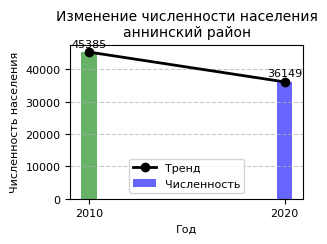
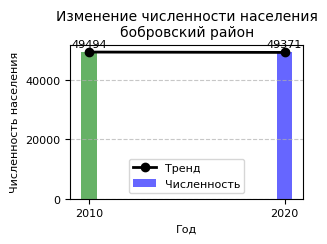
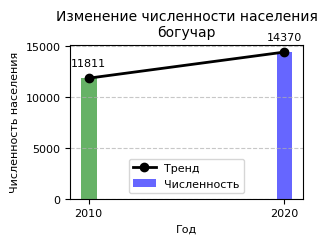
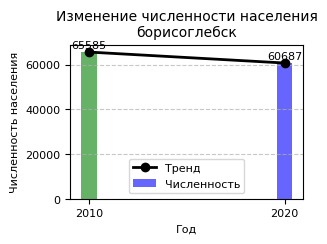
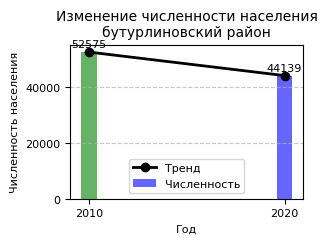
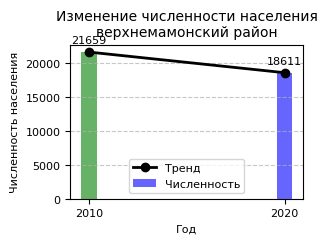
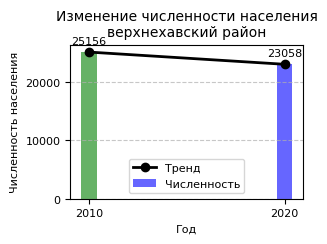
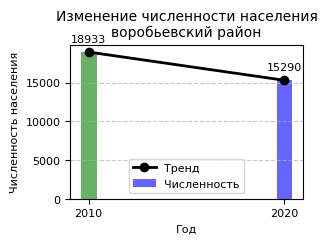
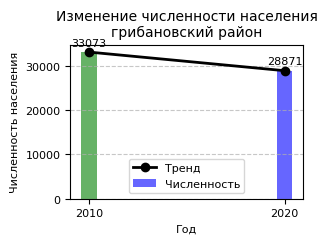
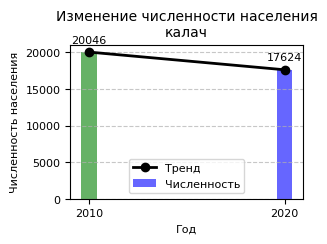
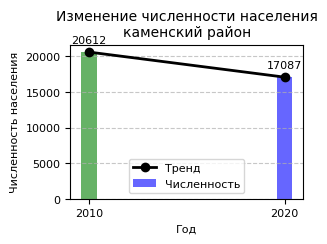
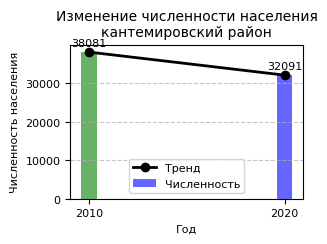
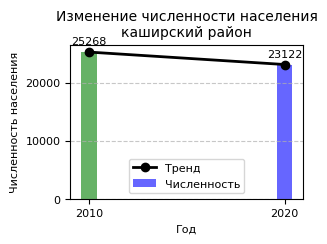
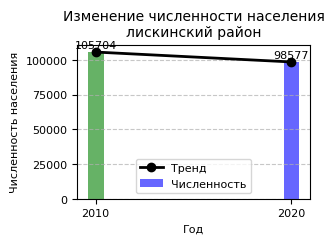
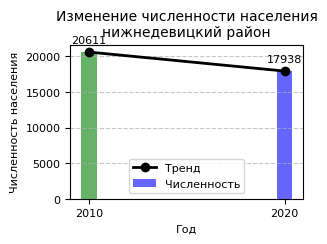
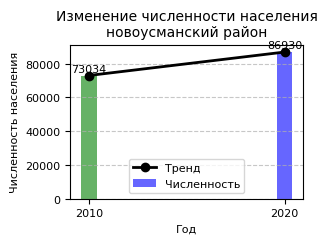
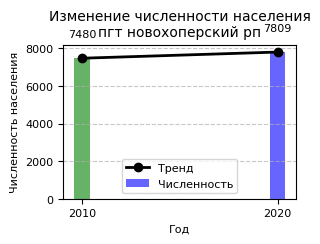
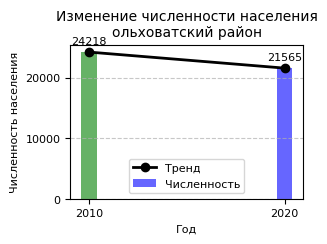
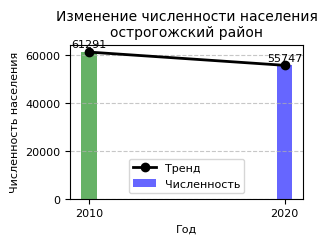
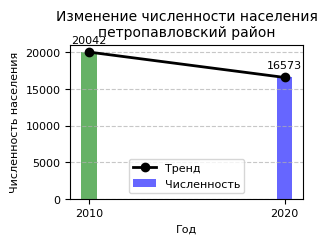
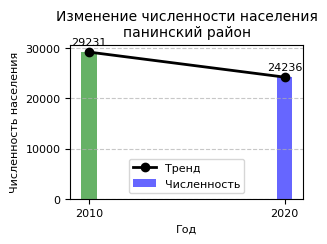
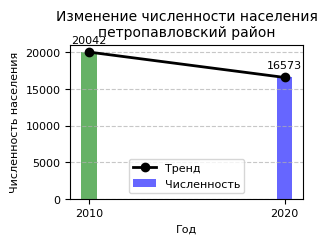
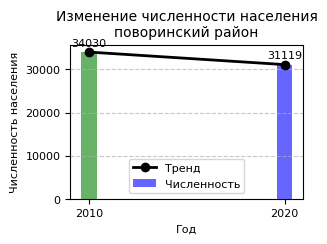
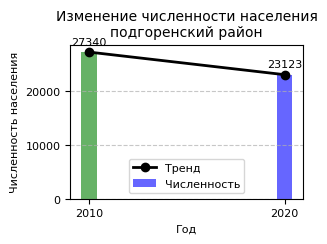
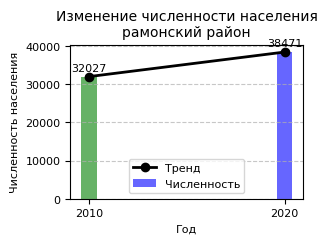
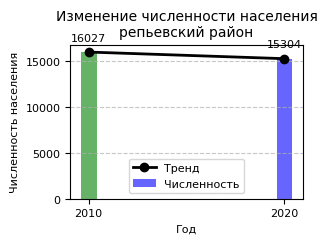
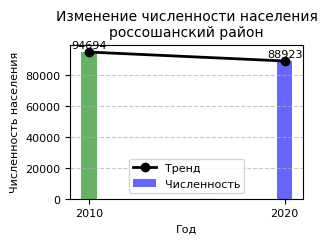
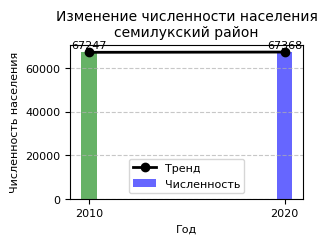
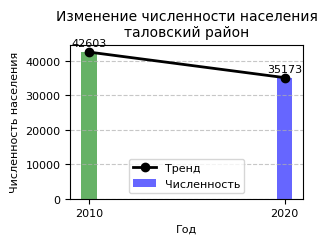
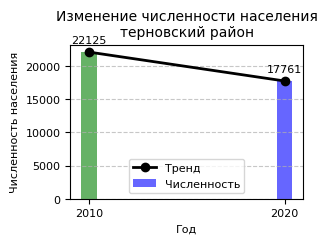
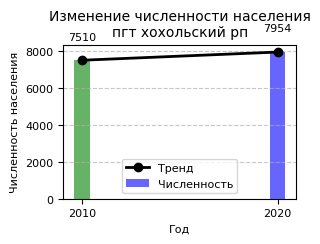
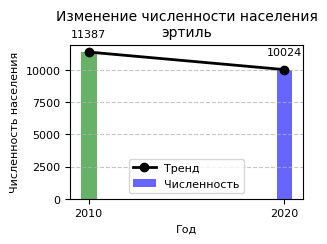
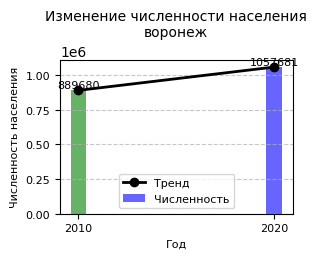
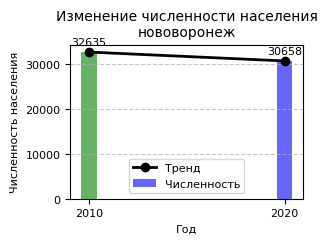

Карта успешно сохранена в файл: map.html


In [3]:
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from fuzzywuzzy import fuzz

# Загрузка комбинированной таблицы
combined_csv_path = input("Введите путь к комбинированной таблице CSV: ").strip()
combined_data_df = pd.read_csv(combined_csv_path, sep=';', encoding='utf-8-sig', header=0)

# Первая строка — рабочие названия столбцов
english_headers = combined_data_df.columns.tolist()

# Вторая строка — русские названия для отображения
russian_headers = combined_data_df.iloc[0].tolist()

# Удаляем первую строку (русские заголовки) из данных
combined_data_df = combined_data_df[1:]

# Приводим данные к нижнему регистру и нормализуем
combined_data_df['region'] = combined_data_df['region'].str.strip().str.lower()

# Функция для нормализации названий регионов
def normalize_region_name(name):
    if not name or not isinstance(name, str):  # Игнорируем пустые или некорректные значения
        return None
    name = name.lower() \
        .replace('городской округ', '') \
        .replace('муниципальный район', '') \
        .replace('сельское население', '') \
        .replace('городское население', '') \
        .replace('г.', '').replace('рц', '').replace('ё', 'е').strip()
    # Убираем пробелы внутри названий для соответствия формату GeoJSON
    return ''.join(e for e in name if e.isalnum() or e.isspace()).strip()

# Нормализуем названия регионов
combined_data_df['region'] = combined_data_df['region'].apply(normalize_region_name)

# Загрузка GeoJSON данных
geojson_path = input("Введите путь к файлу GeoJSON: ").strip()
with open(geojson_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Центр карты
region_center_incsv = [51.67, 39.18]  # Указать центр области
m = folium.Map(location=region_center_incsv, zoom_start=8)

# Создание диаграммы изменения численности населения
def create_population_chart(region_name, combined_data_df, year_columns):
    print('Создание диаграммы для:', region_name)
    region_data = combined_data_df[combined_data_df['region'] == region_name]
    if region_data.empty:
        return None

    years = [int(col.split('_')[-1]) for col in year_columns if col.startswith('total_population')]
    populations = [float(region_data[col].values[0]) for col in year_columns if col.startswith('total_population')]

    plt.figure(figsize=(3, 2))
    bars = plt.bar(years, populations, color=['blue', 'green', 'red'], alpha=0.6, label='Численность')
    plt.plot(years, populations, color='black', marker='o', linewidth=2, label='Тренд')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', va='bottom', fontsize=8)

    plt.title(f'Изменение численности населения\n{region_name}', fontsize=10)
    plt.xlabel('Год', fontsize=8)
    plt.ylabel('Численность населения', fontsize=8)
    plt.xticks(years, fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)

    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()

    return f'<img src="data:image/png;base64,{image_base64}">'

# Функция для поиска наиболее подходящего совпадения
def find_matching_region(target, candidates):
    # Проверка на точное совпадение
    if target in candidates:
        return target

    # Проверка на частичное совпадение
    for candidate in candidates:
        if target in candidate or candidate in target:
            return candidate

    # Если ничего не найдено, используем fuzzywuzzy (в крайних случаях)
    max_similarity = 0
    best_match = None
    for candidate in candidates:
        similarity = fuzz.token_set_ratio(target, candidate)
        if similarity > 85 and similarity > max_similarity:  # Пороговое значение 85%
            max_similarity = similarity
            best_match = candidate

    return best_match

# Функция стиля для GeoJSON
def style_function(feature):
    district_name = feature['properties']['district'].lower().replace(' ', '').replace('район', '').replace('ё', 'е')
    chart_html = ""
    population = 0

    # Список всех регионов из CSV
    csv_regions = combined_data_df['region'].unique()

    # Находим наиболее подходящее совпадение
    match = find_matching_region(district_name, csv_regions)
    if match:
        try:
            # Находим столбцы с численностью населения
            year_columns = [col for col in combined_data_df.columns if col.startswith('total_population')]
            population_value = combined_data_df.loc[combined_data_df['region'] == match, year_columns].values.flatten()[0]
            population = int(float(population_value))  # Преобразуем в целое число
            chart_html = create_population_chart(match, combined_data_df, year_columns)
        except KeyError:
            population = 0

    feature['properties']['total_population'] = population
    feature['properties']['chart_html'] = chart_html if chart_html else "Данные отсутствуют"

    if population != 0 and population < 35000:
        color = 'green'
    elif population < 500000:
        color = 'orange'
    elif population > 500000:
        color = 'red'
    else:
        color = 'grey'

    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.4
    }

# Добавление GeoJSON на карту
folium.GeoJson(
    geojson_data,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['district', 'total_population'],
        aliases=['Район:', 'Численность:'],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['district', 'total_population', 'chart_html'],
        aliases=['Район:', 'Численность:', 'Динамика населения:'],
        localize=True,
        labels=True,
        sticky=True,
        max_width=500,
        parse_html=True
    ),
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
).add_to(m)

# Сохранение карты
output_map_path = input("Введите путь для сохранения карты (например, 'map.html'): ").strip()
if not output_map_path:
    output_map_path = 'map.html'
m.save(output_map_path)
display(m)
print(f"Карта успешно сохранена в файл: {output_map_path}")